# Monte Carlo Methods
This notebook recreates the classic card game Blackjack and trains an agent to play effectively using Monte Carlo Methods.

In [6]:
%matplotlib notebook
import random
import numpy as np
from copy import deepcopy
import gym
import torch
from collections import namedtuple, defaultdict
import matplotlib.pyplot as pp

In [7]:
env = gym.make('Blackjack-v0')
seed = 1412343214
torch.manual_seed(seed)
env.seed(seed) 
print('Initialized seeds')

Initialized seeds


In [8]:
State = namedtuple('State', ['hand', 'dealer', 'usable_ace'])
StateAction = namedtuple('StateAction', ['s', 'a'])
StateActionReward = namedtuple('StateActionReward', ['s', 'a', 'r'])
Outcome = namedtuple('Outcome', ['state', 'reward', 'is_over', 'empty'])

class BlackJackPolicy:
    def __init__(self):
        # state: [(action, prob), (action, prob)]
        self.p = defaultdict(lambda: [(True, 0.5), (False, 0.5)])
        
        # state.action.(sum, count) of post rewards
        self.Q = defaultdict(lambda: defaultdict(lambda: (0, 0)))
    def action(self, state, greedy=False):
        if greedy:
            return max(self.p[state], key=lambda x: x[1])[0]
        else:
            actions = [a[0] for a in self.p[state]]
            probabilities = [p[1] for p in self.p[state]]
            return random.choices(actions, probabilities)[0] # Weighted action
    
    def get_policy(self):
        #usable_ace_f.append((state, max(actions, key=lambda x: x[1])[0]))
        policy = {}
        for state, actions in self.p.items():
            policy[state] = max(actions, key=lambda x: x[1])[0]
        return policy
    def get_state_action_p(self, state, action):
        actions = self.p[state]
        for a,p in actions:
            if a == action:
                return p
        assert('Should never reach here')
            

def episode(policy):
    env.reset()
    finished = False
    state_action_pairs = []
    while not finished:
        state = State(*env._get_obs())
        action = policy.action(state)
        outcome = Outcome(*env.step(action))
        
        state_action_pairs.append(StateActionReward(state, action, outcome.reward))
        finished = outcome.is_over

    return state_action_pairs

## On Policy First-Visit Monte Carlo Control (for epsilon-soft policies)
Estimates optimal policy by generating episodes from the starting state. 'On Policy' refers to using the same policy to guide actions and generate behavior.

In [9]:
def train(epsilon=0.1, iterations=1000):
    policy = BlackJackPolicy()
    Q = policy.Q
    
    for i in range(int(iterations)):
        if i % 100000 == 0 and i > 0:
            print(f'Progress: {int(i * 100 / iterations)}%', end="\r")

        ep_state_actions = episode(policy)                            # generate an episode
        for i,sar in enumerate(ep_state_actions):                     # iterate state-action-rewards in episode
            s = sar.s
            a = sar.a
            returns = sum(map(lambda x: x.r, ep_state_actions[i:]))   # sum of rewards that follows first occurrence
            Q[s][a] = ((Q[s][a][0] + returns), Q[s][a][1] + 1)        # update Q(s,a) sum of rewards and count

        for s in map(lambda sar: sar.s, ep_state_actions):
            a_star = max(Q[s], key=lambda a: Q[s][a][0] / Q[s][a][1]) # argmax action based on Q average
            p_a = 1 - epsilon + (epsilon / 2)                         # probability of best action
            p_na = epsilon / 2                                        # probability of all other actions (only 1 other)
            policy.p[s] = [(a_star, p_a), (not a_star, p_na)]         # update policy probability of action based on state
    return policy

In [5]:
optimal_policy = train(epsilon=0.15, iterations=1e7)

## Disecting the Results
We now have a trained policy with the structure
```
optimal_policy.p = {
  state_0:  # (hand, dealer, usable_ace)
    [ (action, prob), (action, prob) ],
  state_1:
    [ (action, prob), (action, prob) ],
  . . . ,
  state_n:
    [ (action, prob), (action, prob) ]
}
```
Where states `1-n` represent every possible state in our Blackjack environment.
We can group the states together using `usable_ace, dealer` and find the threshold in our `hand` to see when to hit or stick.

## Displaying Results
No one wants to look at the intelligence of an AI agent in the form of raw text. We want to be able to show grandma or grandpa a visual aid to demonstrate what we have achieved.

This portion prepares the data of our trained policy to be shown using a step line graph. The x and y axis show the sum of the dealer's hand and the agent's hand, respectively. Above the line implies to stay, and on or below to hit.

In [6]:
def get_hit_threshold(state_actions):
    thresholds = {}
    for usable_ace in [True, False]:
        thresholds[usable_ace] = {}
        for i in range(1, 11):
            
            # Consider all states with usable_ace, dealer=i
            hit_threshold = []
            for state,hit in state_actions.items():
                if state.usable_ace == usable_ace and state.dealer == i:
                    hit_threshold.append((state, hit))

            # Filter on hands where (action) hit=True
            hit_states = list(filter(lambda x: x[1], hit_threshold))
            
            # Get the max hand value
            max_threshold_state = max(hit_states, key=lambda x: x[0].hand)
            
            thresholds[usable_ace][i] = max_threshold_state[0].hand
    return thresholds

hit_thresholds = get_hit_threshold(optimal_policy.get_policy())       

In [7]:
print(hit_thresholds)

{True: {1: 18, 2: 17, 3: 17, 4: 17, 5: 17, 6: 17, 7: 17, 8: 17, 9: 18, 10: 18}, False: {1: 16, 2: 11, 3: 11, 4: 11, 5: 11, 6: 11, 7: 16, 8: 16, 9: 16, 10: 15}}


In [8]:
def plot_threshold_data(hit_thresholds, usable_ace):
    x = []
    y = []
    for dealer,threshold in hit_thresholds[usable_ace].items():
        x.append(dealer)
        y.append(threshold)
    # Add extra value for step plot
    x.append(x[-1] + 1)
    y.append(y[-1])
    return (x,y)

plot_data_ace_t = plot_threshold_data(hit_thresholds, usable_ace=True)
plot_data_ace_f = plot_threshold_data(hit_thresholds, usable_ace=False)

print('([Dealer Showing], [When to Hit <=])')
print(plot_data_ace_t)
print(plot_data_ace_f)

([Dealer Showing], [When to Hit <=])
([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [18, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18])
([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [16, 11, 11, 11, 11, 11, 16, 16, 16, 15, 15])


<IPython.core.display.Javascript object>


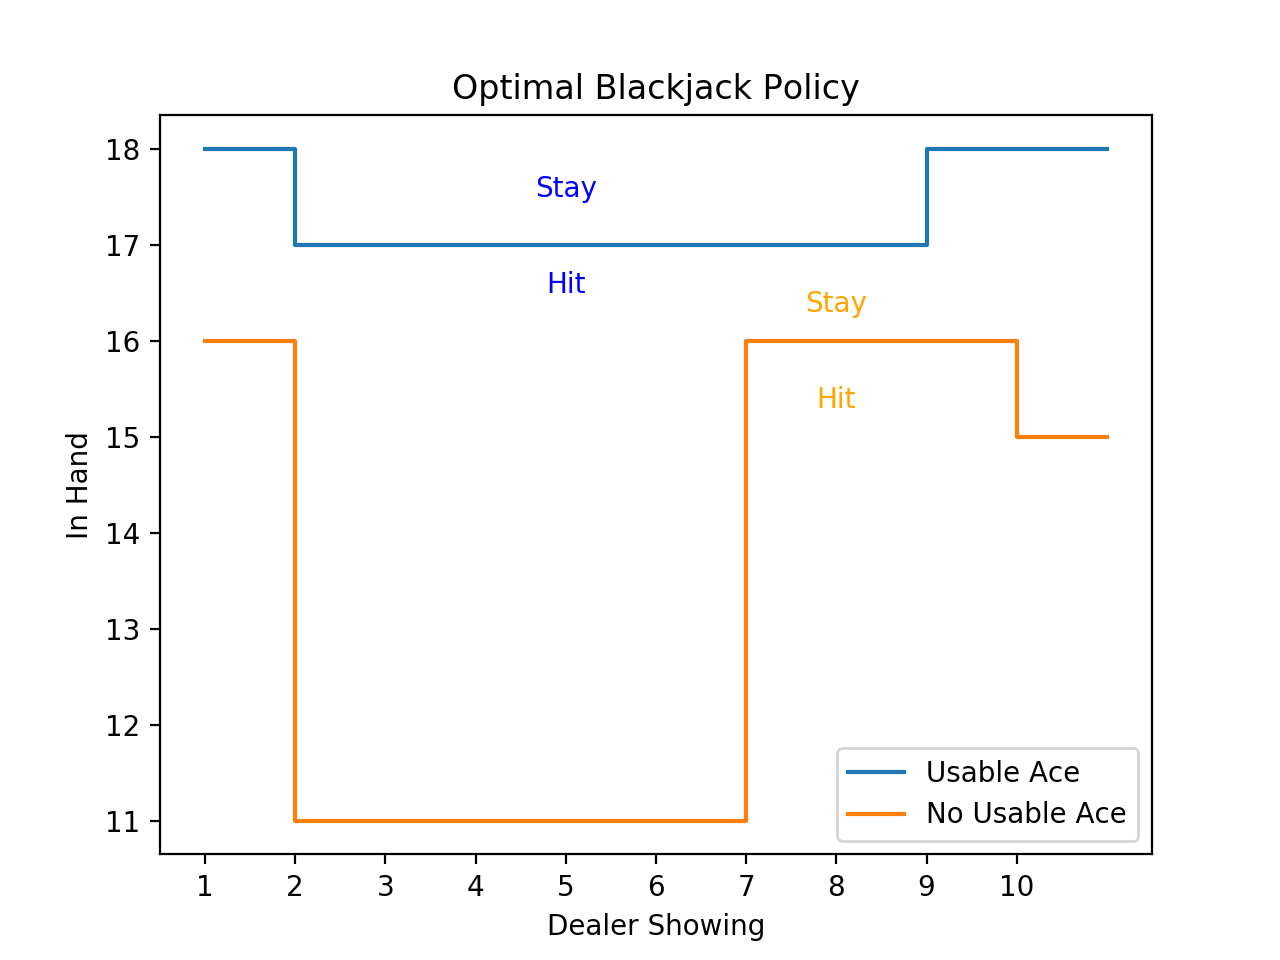

In [57]:
pp.figure()
pp.step(plot_data_ace_t[0], plot_data_ace_t[1], where='post', label='Usable Ace')
pp.text(5, 17.5, 'Stay', color='blue', horizontalalignment='center')
pp.text(5, 16.5, 'Hit', color='blue', horizontalalignment='center')

pp.step(plot_data_ace_f[0], plot_data_ace_f[1], where='post', label='No Usable Ace')
pp.text(8, 16.3, 'Stay', color='orange', horizontalalignment='center')
pp.text(8, 15.3, 'Hit', color='orange', horizontalalignment='center')

pp.xlabel('Dealer Showing')
pp.ylabel('In Hand')
pp.xticks(plot_data_ace_f[0][:-1])
pp.legend()
pp.title('Optimal Blackjack Policy')
pp.show()
print('')

## Importance Sampling Ratio
Now that we have an optimal policy, we can show how a behavioral policy can be used to estimate state-action values of an optimal policy. We consider both ordinary and weighted importance ratio.

In [10]:
behavioral_policy = BlackJackPolicy()

We generate episodes and checkpoint at a log scale to view it's progress.

In [63]:
def generate_episodes(n, policy, state_action_eps):
    for i in range(n):
        ep = episode(policy)
        for i,sat in enumerate(ep):
            state_action = StateAction(sat.s, sat.a)
            state_action_eps[state_action].append(ep[i:])
    return state_action_eps

# Stores all states and actions that proceed StateAction key in an episode
state_action_eps = defaultdict(lambda: [])

log_episode_sets = []
num_episodes = 0
for i in range(6):
    log_episode_sets.append(deepcopy(generate_episodes(10**i - num_episodes, behavioral_policy, state_action_eps)))
    num_episodes += 10**i

Now we can use these series of episodes to compute both ordinary and weighted importance, and it's respective RMSE compared to optimal state-action Q values.

In [71]:
def rmse(behavior_Q, optimal_Q):
    rmse_sum = 0
    rmse_count = 0
    for s,actions in optimal_Q.items():
        for a,q_tuple in actions.items():
            optimal_q = q_tuple[0] / q_tuple[1]
            behavior_q = behavior_Q[StateAction(s,a)]
        
            rmse_sum += (optimal_q - behavior_q)**2
            rmse_count += 1
    return rmse_sum / rmse_count

def compute_importance(state_action_eps, behavioral_policy, optimal_policy, importance_type):
    importances = defaultdict(lambda: 0)
    for state_action,episodes in state_action_eps.items():
        state_action_importance = []
        state_action_returns = []
        for ep in episodes:
            returns = ep[-1].r

            o_state_action_probs = list(map(lambda sar: optimal_policy.get_state_action_p(sar.s, sar.a), ep))
            b_state_action_probs = list(map(lambda sar: behavioral_policy.get_state_action_p(sar.s, sar.a), ep))

            importance_ratio = np.prod(o_state_action_probs) / np.prod(b_state_action_probs)

            state_action_importance.append(importance_ratio)
            state_action_returns.append(returns)

        numerator = np.sum(np.array(state_action_importance) * np.array(state_action_returns))
        
        if importance_type == "ordinary":
            importances[state_action] = numerator / len(episodes)
        elif importance_type == "weighted":
            importances[state_action] = numerator / np.sum(state_action_importance)
        else:
            raise Exception('invalid importance type')
    return importances

def importance_rmse(optimal_policy, behavioral_policy, state_action_eps, importance_type):
    behavior_Q = compute_importance(state_action_eps, behavioral_policy, optimal_policy, importance_type)
    return rmse(behavior_Q, optimal_policy.Q)

In [72]:
ordinary_rmse = [importance_rmse(optimal_policy, behavioral_policy, episodes, importance_type='ordinary') for episodes in log_episode_sets]
weighted_rmse = [importance_rmse(optimal_policy, behavioral_policy, episodes, importance_type='weighted') for episodes in log_episode_sets]

<IPython.core.display.Javascript object>


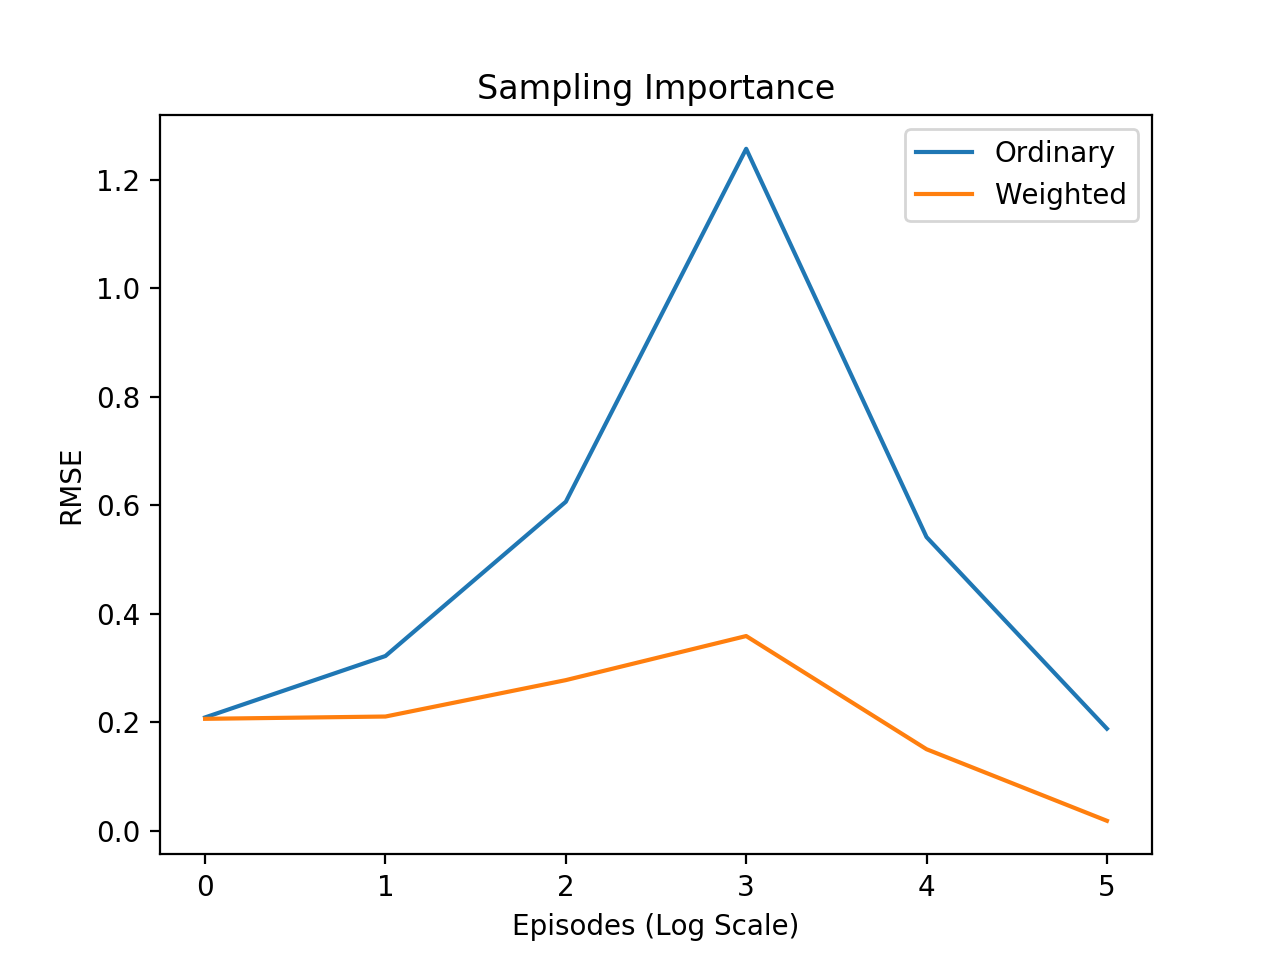

In [80]:
pp.figure()
pp.plot(ordinary_rmse, label='Ordinary')
pp.plot(weighted_rmse, label='Weighted')

pp.xlabel('Episodes (Log Scale)')
pp.ylabel('RMSE')
pp.legend()
pp.title('Sampling Importance')
pp.show()
print('')

## Off-Policy Monte Carlo Control

In [70]:
def train_off_policy(epsilon=0.1, iterations=1, gamma=1):
    policy = BlackJackPolicy()
    Q = policy.Q
    C = defaultdict(lambda: 0)
    
    for i in range(int(iterations)):
        if i % 100000 == 0 and i > 0:
            print(f'Progress: {int(i * 100 / iterations)}%', end="\r")

        b = BlackJackPolicy()
        ep_state_actions = episode(b)
        g = 0
        w = 1
        
        for sar in reversed(ep_state_actions):
            state = sar.a
            action = sar.a
            state_action = StateAction(state, action)
            
            g = (gamma * g) + sar.r
            C[state_action] += w
            Q[state][action] = (Q[state][action][0] + ((w / C[state_action]) * (g - Q[state][action][0])), 1)
            
            if Q[state][True][0] > Q[state][False][0]:
                q_a = True
            else:
                q_a = False
            
            policy.p[state] = [(q_a, 1.0), (not q_a, 0.0)]
            
#             print(action)
#             print(policy.action(state, greedy=True))
#             print("")
            if action != policy.action(state, greedy=True):
#                 print('broke')
                break
            print('not broke')
                
            w *= (1 / b.get_state_action_p(state, action))

In [71]:
train_off_policy(iterations=1000000)

not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke
not broke


KeyboardInterrupt: 